<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/Graphical_NN_21_13_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

# New Section

# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
import Pkg; Pkg.add("InvertedIndices")

In [29]:
using Plots
using LinearAlgebra
using BenchmarkTools
import Random
using InvertedIndices
using BenchmarkTools

In [30]:
using InvertedIndices
using Plots 
using LinearAlgebra
using BenchmarkTools
import Random

function make_mtrx(dimentions, list_1, list_2)
  m = zeros(dimentions, dimentions)
  for i in list_1
    for j in list_2
      m[i, j] = 1
    end
  end
  return m
end


function get_zeros_non_zeros(mtrx, x_dim, y_dim)
  s = 0
    for i in range(1, x_dim)
      for j in range(1, y_dim)
        if (a[i, j] == 0.0)
          s = s + 1
        end
      end
    end
    println("Zeros: $s and Non-zeros: ", x_dim * y_dim - s)
  return s
end


function get_matrix_memory(a_down_lim, a_up_lim, a_dim)
  memory_list = Vector{Float64}()
  benchmarkDicts["memory"] = []
  bb = @benchmark random_matrix($a_down_lim, $a_up_lim, $a_dim, $a_dim)
  push!(benchmarkDicts["memory"], bb.memory)
  return(benchmarkDicts["memory"])
end


function random_matrix(a, b, x_dim, y_dim)
  Random.seed!(1234)
  mtrx = rand(a:b, x_dim, y_dim )
  print(mtrx)
  return mtrx
end

function get_each_element(mtrx, x_dim, y_dim)
  for i in range(1, x_dim)
    for j in range(1, y_dim)
     print("mtrx[$i, $j]  = ", mtrx[i, j], "\n")
    end
  end
end

function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

function initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  print("\n")
  println("Making a matrix, this might take some time...")
  a = random_matrix(a_down_lim, a_up_lim, a_dim, a_dim)
  print("\n")
  println("Calculating aj matrix, this might take some time...")
  aj = A2S(a)
  print("\n")
  println("Making x matrix, this might take some time...")
  x = random_matrix(x_down_lim, x_up_lim, a_dim, x_y_dim)
  print("\n")
  println("Making th matrix, this might take some time...")
  th = random_matrix(th_down_lim, th_up_lim, x_y_dim, th_y_dim)
  print("\n")
  println("Calculating final matrix, final = aj * x * th ")
  Final = aj * x * th  
  return a, aj, x, th, Final
end



function reduce_size(a, x, th, n_col_row_to_reduce)
  x_dim = size(a, 1)
  y_dim = size(a, 2)
  a_reduced = a[Not(x_dim - n_col_row_to_reduce: end), Not(y_dim - n_col_row_to_reduce : end)]
  aj_reduced = A2S(a_reduced)
  x_reduced = x[Not(x_dim - n_col_row_to_reduce: end), :]
  Final_reduced = aj_reduced * x_reduced * th
  return Final_reduced
  end


function mae(mtrx, mtrx_reduced)
  x = size(mtrx_reduced, 1)
  y = size(mtrx_reduced, 2)
  s = 0
  for i in range(1, x)
    for j in range(1, y)
      s = s + abs(mtrx[i, j] - mtrx_reduced[i, j])
    end
  end
  mae = sqrt(s/(x*y))
  return mae 
  end
  


function total_error(n_drop_row_col, a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim )
  mean_average_error = Vector{Float64}()
  a, aj, x, th, Final = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  for i in range(-1, n_drop_row_col)
    F1 = reduce_size(a, x, th, i)
    MAE = mae(Final, F1)
    append!(mean_average_error,MAE)
  end
  skip = collect(-1: n_drop_row_col)
  return(mean_average_error, skip)
  end

 function split_alpha_matrix(a_mtrx, n_lines_to_split)
  x = size(a_mtrx, 1)
  y = size(a_mtrx, 2)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  count = 1
  k = 1
  for i in range(1, n_lines_to_split)
    z = 1
    for j in range(1, n_lines_to_split)
      dictionary["a_$count"] = a_mtrx[k: k + n - 1, z: j*n ]
      count = count + 1
      z = z + n
    end
    k = k + n
  end
  #show(stdout, "text/plain", dictionary["a_1"])
  return(dictionary)
end


function split_x_matrix(x_mtrx, n_lines_to_split)
  x = size(x_mtrx, 1)
  n = div(x, n_lines_to_split)
  print(n)
  dictionary = Dict()
  z = 1
  for i in range(1, n_lines_to_split)
    dictionary["x_$i"] = x_mtrx[z : z + n - 1 , 1:end]
    z = z + n
  end
  #show(stdout, "text/plain", dictionary["x_3"])
  return(dictionary)
  end 

 function dictionary_to_matrix(dict, x_splited_length, x_y_dim, x_mtrx, n_lines_to_split)
  i = 1 
  mtrx_reduced_dictionary = Dict()
  count = 1
  num = div(size(x_mtrx, 1), n_lines_to_split)
  while (i <= length(dict)) 
    s = zeros(num, x_y_dim)
    k = 1 
    while k <= x_splited_length  
      s = s + dict["aj_x_$i"] 
      k = k + 1 
      i = i + 1
    end 
  mtrx_reduced_dictionary["A_$count"] = s
  count = count + 1
  end 
  s_ = vcat(mtrx_reduced_dictionary["A_1"])
  for i in range(2, length(mtrx_reduced_dictionary))
    aux = vcat(s_, mtrx_reduced_dictionary["A_$i"])
    s_ = aux
  end
  return s_ 
end 


function multiply_splited(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim, n_lines_to_split)
  a_mtrx,  aj_mtrx, x_mtrx, th_mtrx, final_mtrx  = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  aj_splited = Dict()
  print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end


function multiply_splited_2(a_mtrx, x_mtrx, th_mtrx, n_lines_to_split)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  x_y_dim = size(x_mtrx, 2)
  aj_splited = Dict()
  print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end


multiply_splited_2 (generic function with 1 method)

In [ ]:
error_, skip_ = total_error(200, 1000, 0, 10, 10, -4, 4, 5, -2, 2)

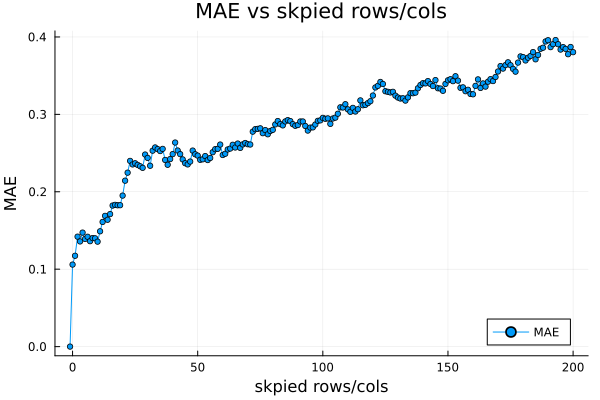

In [32]:
plot(skip_, # x-axis
    error_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs skpied rows/cols",
    xlabel = "skpied rows/cols",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [ ]:
a, aj, x, th, final = initial_matrix(1000, 0, 150, 20, -4, 4, 5, -2, 2)

final

In [ ]:
f = multiply_splited_2(a, x, th, 1)

In [ ]:
mae_splited = Vector{Float64}()
for i in range(1, 100)
  println("--- $i ---")
  f = multiply_splited_2(a, x, th, i)
  mae_spl = mae(final, f)
  append!(mae_splited, mae_spl)
  end

In [ ]:
println(length(mae_splited))
counter = 1
counter_list = Vector{Float64}()
for i in mae_splited
  println("$counter, $i")
  append!(counter_list, counter)
  counter = counter + 1
end

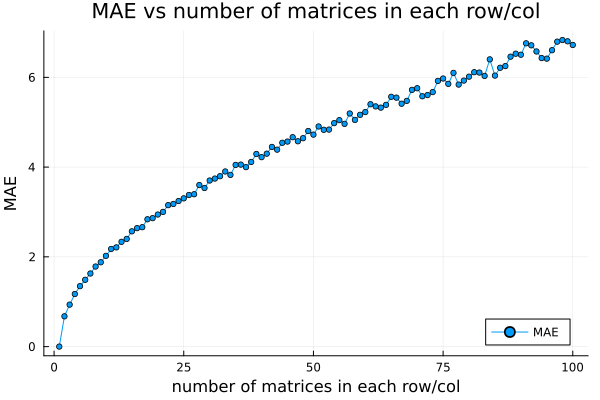

In [37]:
plot(counter_list, # x-axis
    mae_splited, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs number of matrices in each row/col",
    xlabel = "number of matrices in each row/col",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [ ]:
function get_matrix_memory(a_down_lim, a_up_lim, a_dim)
  benchmarkDicts = Dict()
  memory_list = Vector{Float64}()
  benchmarkDicts["memory"] = []
  bb = @benchmark random_matrix($a_down_lim, $a_up_lim, $a_dim, $a_dim)
  push!(benchmarkDicts["memory"], bb.memory)
  return(benchmarkDicts["memory"]/1000000)
end

get_matrix_memory(0, 150, 1000)

bb = @benchmark split_alpha_matrix($a, 100)

number_of_rows = 5
mat = random_matrix(0, 150, 10, 10)
for i in range(1, number_of_rows - 1)
  aux_ = vcat(mat, random_matrix(0, 150, 10, 10))
  mat = aux_
end
for i in range(1, number_of_rows - 1)
  aux_ = hcat(mat, random_matrix(0, 150, 50, 10))
  mat = aux_
end
print("\n")
show(stdout, "text/plain", mat)

function create_mtrx_efficiently()
number_of_rows = 5
mat = random_matrix(0, 150, 10, 10)
for i in range(1, number_of_rows - 1)
  aux_ = vcat(mat, random_matrix(0, 150, 10, 10))
  mat = aux_
end
for i in range(1, number_of_rows - 1)
  aux_ = hcat(mat, random_matrix(0, 150, 50, 10))
  mat = aux_
end
print("\n")
show(stdout, "text/plain", mat)
return (mat)
end

l = @benchmark create_mtrx_efficiently()

function create_2()
  a_f_row = vcat(a, a, a, a, a, a, a, a, a, a)
  a_f_col = hcat(a, a, a, a, a, a, a, a, a, a)
  ff = a_f_row * a_f_col
  end

  function create_3()
  a_f_row = a 
  a_f_col = a
  for i in range(1, 1000 -1)
      println("--- $i row ---")
    a_f_row = vcat(a_f_row, a)
  end
  for i in range(1, 1000 -1)
    println("--- $i col ---")
    a_f_col = hcat(a_f_col, a)
  end
  ff = a_f_row * a_f_col
  return(ff)
  end

get_matrix_memory (generic function with 1 method)

In [40]:
function random_matrix_new(a, b, x_dim, y_dim)
  mtrx = rand(a:b, x_dim, y_dim )
  print(mtrx)
  return mtrx
end

random_matrix_new (generic function with 1 method)

In [ ]:
benchmarkDicts = Dict()
benchmarkDicts["memory"] = []
i_list = []
for i in 100:100:1000
  mem = @benchmark random_matrix_new(0, 150, $i, $i)
  push!(benchmarkDicts["memory"], mem.memory/1000000)
  append!(i_list, i)
end
print(benchmarkDicts["memory"])

In [ ]:
println(benchmarkDicts["memory"])
println(i_list)

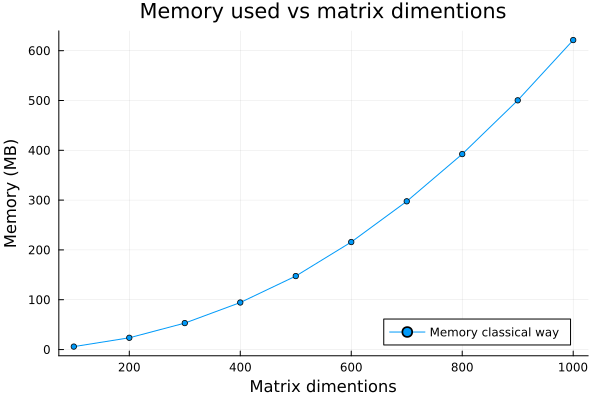

In [43]:
plot(i_list, # x-axis
    benchmarkDicts["memory"], # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Memory classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")

In [ ]:
function create_3(a_dim, final_dim)
  a_test = random_matrix_new(0, 150, a_dim, a_dim)
  a_f_row = a_test
  a_f_col = a_test
  for i in range(1, final_dim/a_dim -1)
    a_f_row = vcat(a_f_row, random_matrix_new(0, 150, a_dim, a_dim))
  end
  for i in range(1, final_dim/a_dim -1)
    a_f_col = hcat(a_f_col, random_matrix_new(0, 150, a_dim, a_dim))
  end
  print("\n")
  ff = a_f_row * a_f_col
  return(ff)
  end

  mat = create_3(1, 550)

In [ ]:
size(mat,2)

In [ ]:
benchmarkDicts1 = Dict()
benchmarkDicts1["memory"] = []
i_list1 = []
for i in 1000:1000:10000
  mem = @benchmark create_3(1, $i)
  push!(benchmarkDicts1["memory"], mem.memory/1000000)
  append!(i_list1, i)
end
print(benchmarkDicts1["memory"])

In [ ]:
benchmarkDicts2 = Dict()
benchmarkDicts2["memory"] = []
i_list2 = []
for i in 1000:1000:10000
  mem = @benchmark create_3(5, $i)
  push!(benchmarkDicts2["memory"], mem.memory/1000000)
  append!(i_list2, i)
end
print(benchmarkDicts2["memory"])

In [82]:
benchmarkDicts3 = Dict()
benchmarkDicts3["memory"] = []
i_list3 = []
for i in 1000:1000:10000
  mem = @benchmark create_3(100, $i)
  push!(benchmarkDicts3["memory"], mem.memory/1000000)
  append!(i_list3, i)
end
print(benchmarkDicts3["memory"])

[73 150 17 95 139 88 146 37 44 150 12 51 140 23 15 117 29 105 24 90 73 51 78 26 21 1 53 97 129 92 123 132 119 8 73 129 105 79 30 121 110 33 79 100 17 116 21 23 92 11 27 69 61 80 14 123 115 63 1 34 116 118 117 49 127 105 134 12 67 3 33 117 6 102 57 125 16 118 138 38 2 18 97 106 103 128 44 83 126 93 113 115 101 28 9 143 133 99 114 80; 86 38 85 84 117 42 104 141 8 23 11 27 51 141 12 50 71 138 2 15 35 137 21 14 2 88 28 64 69 78 81 18 106 16 118 5 44 76 80 88 129 83 22 28 137 16 106 30 142 91 89 95 51 0 131 78 12 142 39 118 37 24 19 68 55 148 73 42 43 51 10 6 71 57 15 23 143 140 90 8 141 124 62 92 141 123 53 15 57 126 45 48 122 10 23 11 44 125 122 110; 48 111 7 4 67 70 21 138 2 39 7 127 125 75 130 53 65 84 50 145 54 33 128 4 146 78 33 115 20 18 39 27 39 37 56 84 28 18 0 90 9 101 85 13 0 101 61 57 83 134 72 28 111 110 87 93 50 137 91 143 139 149 10 138 126 132 100 129 65 132 98 29 126 86 67 31 3 88 76 114 67 99 8 6 86 109 54 45 107 31 130 105 24 96 17 64 128 34 81 108; 54 93 40 142 9 102 100

Excessive output truncated after 524289 bytes.

 131 116 133 131 85 47 13 81 131 52 2; 31 25 100 129 84 112 72 99 114 121 6 101 90 37 58 27 1 113 19 88 119 48 50 43 101 23 115 36 99 59 80 23 27 113 35 14 130 27 91 21 43 119 145 121 110 33 65 26 69 26 14 64 8 134 125 3 58 50 39 111 64 128 9 128 72 125 46 125 135 120 113 9 85 120 33 0 121 121 2 101 78 139 110 109 51 139 25 4 33 63 42 7 133 143 96 47 140 128 68 34; 9 112 83 17 143 142 134 145 28 128 49 82 122 38 113 26 101 62 112 103 19 139 116 127 16 131 121 32 143 7 62 64 8 135 19 120 147 100 127 43 90 148 116 127 31 119 39 136 88 81 45 64 20 37 52 9 35 141 121 150 70 37 75 141 46 70 125 38 9 64 42 8 76 1 10 82 67 84 150 133 36 13 116 74 101 123 36 37 95 58 112 47 85 63 112 14 86 39 141 125; 13 20 72 72 147 137 60 129 73 91 5 65 145 141 16 149 143 4 144 103 82 24 12 125 8 142 114 32 9 112 134 4 52 86 119 128 77 33 21 51 10 138 23 111 81 81 0 23 28 2 89 49 106 93 11 71 88 77 111 47 62 83 36 134 45 87 122 79 14 8 34 12 57 121 84 54 8 110 59 51 28 11 67 73 7 8 89 59 50 19 31 53 40 139 1

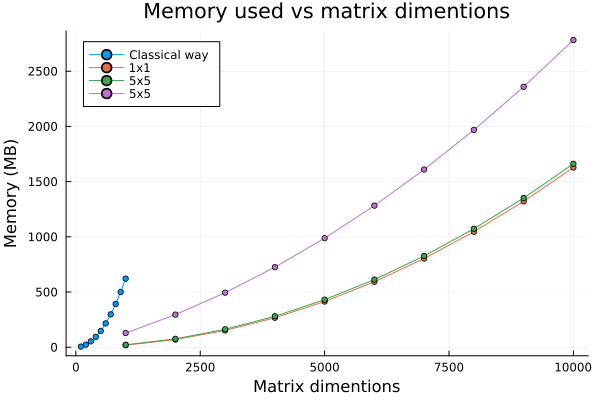

In [85]:
x =  i_list
y = benchmarkDicts["memory"] 

x1 = i_list1
y1 = benchmarkDicts1["memory"] 

x2 = i_list2
y2 = benchmarkDicts2["memory"] 

x3 = i_list3
y3 = benchmarkDicts3["memory"] 

plot(x, # x-axis
    y, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")


    plot!(x1, # x-axis
    y1, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "1x1",
    legend=:topleft,
    ylabel = "Memory (MB)")

    plot!(x2, # x-axis
    y2, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "5x5",
    legend=:topleft,
    ylabel = "Memory (MB)")

    plot!(x3, # x-axis
    y3, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "5x5",
    legend=:topleft,
    ylabel = "Memory (MB)")

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />